In [1]:
import os, sys, time, copy
from math import log, sqrt, floor
import numpy as np
import matplotlib.pyplot as plt
import pickle
import bisect

import myokit
from scipy.integrate import ode, solve_ivp, odeint
sys.path.append('../')
sys.path.append('../Lib')
import mod_trace as trace

sys.path.append('../Protocols')
from pacing_protocol import PacingProtocol
import mod_protocols

sys.path.append('../Models')
import ord2011JK_v1 
import ord2011JK_fc 

from numbalsoda import lsoda_sig, lsoda
from numba import njit, cfunc

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
'''
O'Hara-Rudy CiPA v1.0 (2011)
'''
cells = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
cell_mode = cells['Epicardial']
end_time = 500
bcl = 1000
duration = 0.5
offset = 20

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 5000)  

In [3]:
import simulator_myokit
'''
Simulation with Myokit
'''
model_path = "../mmt-model-files/ord-2011.mmt" 
protocol_myokit = myokit.pacing.blocktrain(bcl, duration, offset=offset) # period, duration, offset=0, level=1.0, limit=0
sim_myokit = simulator_myokit.Simulator(model_path, max_step=None, abs_tol=1e-08, rel_tol=1e-10)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ORD2011"
sim_myokit.bcl = bcl

In [4]:
start_time = time.time()

sim_myokit.simulation.set_constant('cell.mode', cell_mode)    
sim_myokit.simulation.set_protocol(protocol_myokit)
y0 = sim_myokit.pre_simulate( bcl*100, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=t_eval, extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1' ])

# current_response_info = trace.CurrentResponseInfo(protocol)
# if self.current_response_info:  # 'INa', 'INaL', 'Ito', 'ICaL', 'IKr', 'IKs', 'IK1'
#     current_timestep = [
#         trace.Current(name='I_Na', value=INa),
#         trace.Current(name='I_NaL', value=INaL),                
#         trace.Current(name='I_to', value=Ito),
#         trace.Current(name='I_CaL', value=ICaL),
#         trace.Current(name='I_Kr', value=IKr),
#         trace.Current(name='I_Ks', value=IKs),
#         trace.Current(name='I_K1', value=IK1),
#     ]
#     self.current_response_info.currents.append(current_timestep)

# trace.Current(name='I_Na', value=d_myokit['ina.INa']),
# trace.Current(name='I_NaL', value=d_myokit['inal.INaL']),                
# trace.Current(name='I_to', value=d_myokit['ito.Ito']),
# trace.Current(name='I_CaL', value=d_myokit['ical.ICaL']),
# trace.Current(name='I_Kr', value=d_myokit['ikr.IKr']),
# trace.Current(name='I_Ks', value=d_myokit['iks.IKs']),
# trace.Current(name='I_K1', value=d_myokit['ik1.IK1']),
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.0375368595123291 seconds ---


In [5]:
import simulator_scipy
'''
Simulation with BDF
'''
protocol = PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
model1 = ord2011JK_v1.ORD2011(protocol)
sim1 = simulator_scipy.Simulator(model1)

start_time = time.time()

model1.y0 = y0
model1.cell.mode = cell_mode
# y0 = sim1.pre_simulate( pre_step=5000, protocol='constant' )        
sol1 = sim1.simulate(t_span=t_span, t_eval=t_eval, method='LSODA', max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10

print("--- %s seconds ---"%(time.time()-start_time))

--- 2.246399164199829 seconds ---


In [6]:
import simulator_scipy
'''
Simulation with BDF
'''
protocol = PacingProtocol(level=1, start=offset, length=duration, period=bcl, multiplier=0, default_time_unit='ms')
model2 = ord2011JK_v1.ORD2011(protocol)
sim2 = simulator_scipy.Simulator(model2)

start_time = time.time()

model2.y0 = y0
model2.cell.mode = cell_mode
# sim2.pre_simulate2( pre_step=bcl*100, protocol='pacing' )        
sol2 = sim2.simulate2(times=t_eval, max_step=0.5, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10

print("--- %s seconds ---"%(time.time()-start_time))

--- 2.2254676818847656 seconds ---


In [7]:
# start_time = time.time()

# funcptr = ord2011JK_fc.ORD2011_AP.address # address to ODE function
# p = np.zeros(10)
# sol3, success = lsoda(funcptr, u0=np.array(model1.y0), t_eval=t_eval, data=p)

# print("--- %s seconds ---"%(time.time()-start_time))
# success

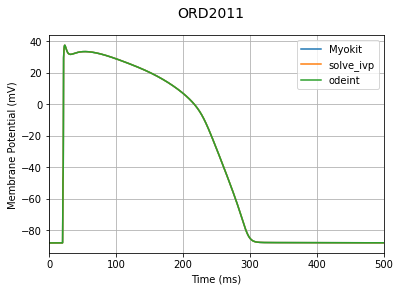

In [8]:
'''
Plot
'''
fig, ax = plt.subplots( figsize=(6,4))    
fig.suptitle(model1.name, fontsize=14)
    
# ax.set_title('Simulation %d'%(simulationNo))
ax.set_xlim(model1.times.min(), model1.times.max())
# ax.set_ylim(ylim[0], ylim[1])
ax.set_ylabel('Membrane Potential (mV)')  
ax.set_xlabel('Time (ms)')  
ax.plot( d_myokit['engine.time'], d_myokit['membrane.V'], label='Myokit') 
ax.plot(model1.times, model1.V, label='solve_ivp')      
ax.plot(model2.times, sol2[0], label='odeint')      
# ax.plot(model1.times, sol3[:, 0], label='lsoda2')      
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], \
#             GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
#     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
#     fig1 = plt.gcf()
ax.legend()
ax.grid()
    
plt.show()
fig.savefig(os.path.join('Results', "ORD2011-JK-scipy"), dpi=100)

In [9]:
print("Complete")

Complete
